Identifying Entities in health care data.
Importing the required packages

In [2]:
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import pandas as pd

#model = spacy.load("en_core_web_sm")
import spacy.cli
model = spacy.load("en_core_web_sm")

Data Preprocessing
------------------------------

The dataset provided is in the form of one word per line. Let's understand the format of data below:

    -> Suppose there are x words in a sentence, then there will be x continuous lines with one word in each line.
    -> Further, the two sentences are separated by empty lines. The labels for the data follow the same format.
        We need to pre-process the data to recover the complete sentences and their labels.

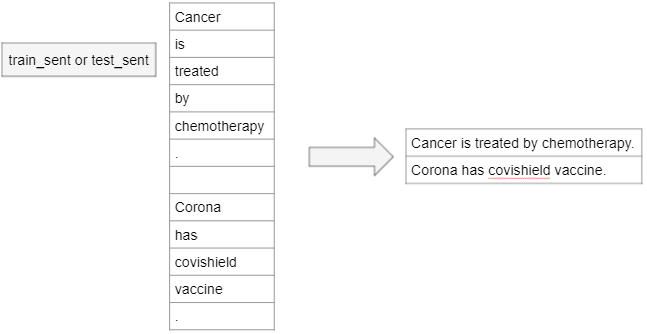

In [3]:
def preprocess_inputfile(input_file):
    i_file = open(input_file)
    file_name = i_file.readlines()
    i_file.close()
    output_list = []
    full_sentence = ""
    
    for each_word in file_name:
        each_word = each_word.strip()
        if each_word =="":
            output_list.append(full_sentence)
            full_sentence = ""
        else:
            if full_sentence:
                full_sentence += " " + each_word
            else:
                full_sentence = each_word
                
    return output_list

In [4]:
train_data = preprocess_inputfile(r'/home/chaitanya/AI & ML upgrad/nlp/project/train_sent')
train_labels = preprocess_inputfile(r'/home/chaitanya/AI & ML upgrad/nlp/project/train_label')
test_data = preprocess_inputfile(r'/home/chaitanya/AI & ML upgrad/nlp/project/test_sent')
test_labels = preprocess_inputfile(r'/home/chaitanya/AI & ML upgrad/nlp/project/test_label')


In [5]:
for each_item in range(10):
    print(f"data {each_item+1} is: {train_data[each_item]}")
    print(f"Label {each_item+1} is: {train_labels[each_item]}")
    print("*"*100)

data 1 is: All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
Label 1 is: O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
****************************************************************************************************
data 2 is: The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Label 2 is: O O O O O O O O O O O O O O O O O O O O O O O O O
****************************************************************************************************
data 3 is: Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
Label 3 is: O O O O O O O O O O O O O O O
****************************************************************************************************
data 4 is: The `` corrected '' cesarean rate ( ma

In [6]:
# Need to figure out the sentences in the processed train and 
#test dataset

print(f"Number of sentences in processed train dataset is: {len(train_data)}")
print(f"Number of sentences in processed test dataset is: {len(test_data)}")

Number of sentences in processed train dataset is: 2599
Number of sentences in processed test dataset is: 1056


In [7]:
print(f"Number of sentences in processed train labels is: {len(train_labels)}")
print(f"Number of sentences in processed test labesl is: {len(test_labels)}")

Number of sentences in processed train labels is: 2599
Number of sentences in processed test labesl is: 1056


In [8]:
# Need to figure out the concepts in the data set like noun, pronoun

In [9]:
n_p_t_list = []

In [10]:
for data in(train_data, test_data):
    for da in data:
        processed_da = model(da)
        for each_token in processed_da:
            if each_token.pos_ == "NOUN" or each_token.pos_=="PROPN":
                n_p_t_list.append(each_token.text)

In [11]:
df_noun_propn = pd.Series(n_p_t_list)

Print first common tokens with NOUN or PROPN PoS tags

In [12]:
df_noun_propn.value_counts().sort_values(ascending = False).head(20)

patients        492
treatment       281
%               247
cancer          200
therapy         175
study           154
disease         142
cell            140
lung            116
group            94
chemotherapy     88
gene             87
effects          85
results          77
women            77
use              75
surgery          71
cases            71
risk             71
analysis         70
dtype: int64

In [13]:
# Need to define the features for the CRF

def getFeaturesForOneWord(data, pos, pos_tags):
    word = data[pos]
    'word.lower=' + word.lower(),
#    'word[-4]=' + word[-4:],
    'word[-3]=' + word[-3:],
    'word[-2]=' + word[-2:],
    'word.isupper=%s' % word.isupper(),
    'word.isdigit=%s' % word.isdigit(),
    'word.startsWithCapital=%s' %word[0].isupper(),
    'word.pos=' + pos_tags[pos]
    
    if(pos > 0):
        prev_word = data[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(), 
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
        'prev_word.pos=' + pos_tags[pos-1]
      ])

    else:
        features.append('BEG')
        
    if(pos == len(sentence)-1):
        features.append('END') 

    return features

In [14]:
# Function to get the features for a sentence
def getFeaturesForOneData(Data):
    processed_data = model(data)
    postags = []
    
    for each_token in processed_data:
        postags.append(each_token.pos_)
    data_list = data.split()
    return [getFeaturesForOneWord(data_list, pos, postags) for pos in range(len(data_list))]

Function to get the labels

In [15]:
def getLabelsInListForOneData(labels):
    return labels.split()

In [16]:
X_train = [getFeaturesForOneData(data) for data in train_data]
X_test = [getFeaturesForOneData(data) for data in test_data]

ValueError: [E1041] Expected a string, Doc, or bytes as input, but got: <class 'list'>

In [ ]:
y_train = [getFeaturesForOneData(data) for data in train_data]
y_test = [getFeaturesForOneData(data) for data in test_data]

In [17]:
#Build the CRF Model

crf = sklearn_crfsuite.CRF(max_iterations = 100)

In [18]:
try:
    crf.fit(X_train, y_train)
except AttributeError:
    pass

NameError: name 'X_train' is not defined

In [19]:
# Evaluation
#Predicting the labels of each of the tokens in the each sentence and the predicted lsabels of the test dataset

y_pred = crf.predict(X_test)

f1_score = metrics.flat_f1_score(y_test, Y_pred, average = 'weighted')
print(f"score is: {round(f1_score, 4)}")

NameError: name 'X_test' is not defined

In [20]:
# Here we are identifying the diseases with the help of custom NER
Dis_Treat_dict = dict()

for i in range(len(Y_pred)):
    val = Y_pred[i]
    
    Diseases = ""
    Treatments = ""
    for j in range(len(val)):
        if val[j] == 'D': 
            Diseases += test_sentences[i].split()[j] + " "
        elif val[j] == 'T': 
            Treatments += test_sentences[i].split()[j] + " "
   
    Diseases = Diseases.lstrip().rstrip()
    Treatments = Treatments.lstrip().rstrip() 
    if Diseases != "" and Treatments != "":
        if Diseases in D_T_dict.keys():
            treat_out = list(Dis_Treat_dict[Diseases])
            treat_out.append(Treatments)
            D_T_dict[Diseases] = treat_out
        elif Diseases not in Dis_Treat_dict.keys():
            Dis_Treat_dict[Diseases] = Treatments


NameError: name 'Y_pred' is not defined

We are defing the logic to get all the predicted tratments from above the function.